In [1]:
import os
%cd ..
import numpy as np
import random
import keras_tuner as kt
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as layers
from tensorflow.keras.layers import GlobalMaxPooling2D, Activation, Dense, Conv1D, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras import optimizers

%matplotlib inline
import matplotlib.pyplot as plt

from tensorflow.keras import regularizers



from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# from utils.deep import preProcess
from utils.visualize import showMe
from config.armband import settings
%load_ext autoreload
%autoreload 2

c:\Users\Gyuri\Desktop\Coding\Python\Armband


In [2]:
classes = settings["classes"]

def smoothLabels(label, factor = 0.):
    label *= (1 - factor)
    label += (factor / len(label))
    return label

def oneHot(label, classes = classes):
    label = to_categorical(label,num_classes=len(classes))
    return smoothLabels(label)

def applyOneHot(data):
    new = []
    for y in data:
        new.append(oneHot(y))
    return np.array(new)

def preProcess(data, input_length):
    d = data.copy()
    d = np.clip(d, -input_length, input_length)
    d /= input_length
    
    return np.array(d)

In [3]:
resource_path = 'data/'
data = []

for subject in os.listdir(resource_path):
    for gesture in os.listdir(resource_path + subject):
        for file in os.listdir(resource_path + subject + '/' + gesture):
            data.append([resource_path + subject + '/' + gesture + '/' + file])

print('Number of gesture samples:', len(data))

Number of gesture samples: 124


In [4]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 1-(train_ratio+val_ratio)

train_sessions = data[:int(len(data)*train_ratio)]
val_sessions = data[int(len(data)*train_ratio):int(len(data)*(train_ratio+val_ratio))]
test_sessions  = data[int(len(data)*(train_ratio+val_ratio)):]

In [5]:
print(len(train_sessions), len(val_sessions), len(test_sessions))

99 12 13


In [6]:
input_length = 10000
categories = []

for _ in range(len(classes)):
    categories.append([])

gestures = list(map(lambda x: x[0].split('/')[-1].split('.')[0], train_sessions))

for i, data_path in enumerate(train_sessions):
    categories[classes.index(gestures[i])].append(np.load(data_path[0]))

for i, category in enumerate(categories):
    categories[i] = np.concatenate((category),axis=0)
    # categories[i] = preProcess(categories[i], input_length)

In [7]:
print(categories[0].shape)

(25, 8, 1000)


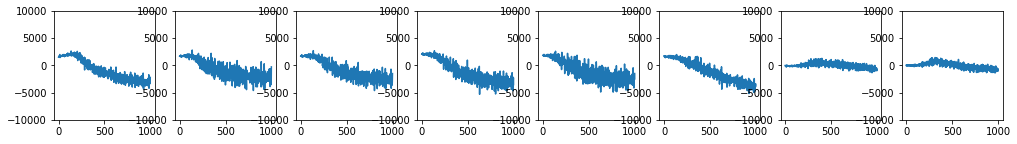

In [8]:
for i in range(len(categories)):
    rests_avg = categories[i].mean(axis=0)
    showMe(rests_avg, range=[-input_length, input_length], clear=True)

In [9]:
y = []

for i in range(len(categories)):
    if i == 0:
        y.append(np.zeros(categories[0].shape[0]))
    else:
        y.append(np.ones(categories[i].shape[0])*i)

X = np.concatenate(categories, axis = 0)
print(y)
y = np.concatenate(y, axis = 0)
print(y)


#SHUFFLE DATA
c = list(zip(X, y))
random.shuffle(c)
X,y = zip(*c)
X = np.array(X)
y = np.array(y)
# print(y)

y = applyOneHot(y)
print(y)

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.]), array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2.]), array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3.])]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3.]
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 

In [10]:
noise = np.random.normal(0,0.1,X.size)
noise = np.reshape(noise,X.shape)

augmented = X + noise
X_aug = np.concatenate((X,augmented))
y_aug = np.concatenate((y,y))

print(X_aug.shape)
print(y_aug.shape)

(198, 8, 1000)
(198, 4)


In [11]:
def get_hyper_model(hp):
    model = keras.Sequential()
    inspected_chanels= X.shape[1]
    input_length=     X.shape[2]
    input_layer = keras.Input(shape = (inspected_chanels,input_length), name='input')
    x = layers.Flatten()(input_layer)
    l2 = 0.001
    for i in range(hp.Choice('n_layers',[1,2,4,6])):
        x     = layers.Dense(hp.Int('dense',min_value=10,max_value=1000,sampling="log"),kernel_regularizer=regularizers.l2(l2))(x)
        x     = layers.BatchNormalization()(x)
        x     = layers.Dropout(hp.Choice('dropout',[0., 0.1,0.2]))(x)


    output = layers.Dense(3, activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output)


    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log"),
        decay_steps=batch_size*10,
        decay_rate=hp.Choice('decay',[0.1,0.9]))


    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    model.summary()
    return model

In [19]:
skf = StratifiedKFold(n_splits=10)
tf.config.run_functions_eagerly(True)

for train, test in skf.split(X, y.argmax(axis=1)):

    X_train = X[train]
    X_test  = X[test]
    y_train = y[train]
    y_test  = y[test]

    print(X_train.shape)
    print(y_train.shape)

    batch_size = 32 #len(X_train)
    print("Batch size: {}".format(batch_size))

    tuner = kt.tuners.RandomSearch(
        get_hyper_model,
        objective='val_accuracy',
        max_trials=100)

    tuner.search(   X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size,
                    epochs=100,
                    shuffle=True)

    best_model = tuner.get_best_models()[0]
                             
    break
   

(89, 8, 1000)
(89, 4)
Batch size: 32
INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 8, 1000)]         0         
                                                                 
 flatten_1 (Flatten)         (None, 8000)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                80010     
                                                                 
 batch_normalization_1 (Batc  (None, 10)               40        
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 d

C:\Users\Gyuri\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


ValueError: Shapes (32, 4) and (32, 3) are incompatible